# Introduction

In this homework you will be given a chance to explore the properties of word embedding using a pre-trained embedding. Then you will build and train your own embedding using the skip-gram method.

## Files
- `hw03.ipynb`: Notebook file with starter code
- `plot_summaries_tokenized.txt`: training data for skipgram
- `glove_6B_100d_top100k.csv`: pretrained glove embedding

The training data and glove embedding 


## Reading material

1. [Learning representations by back-propagating errors](https://www.nature.com/articles/323533a0)

Recent Turing Reward winner Geoffrey Hinton and coworkers first introduced the concept of words embedding in their 1986 Nature paper.

2. [word2vec](https://code.google.com/archive/p/word2vec/)

Google's word2vec project built on skip-gram and google news data.

3. [Efficient Estimation of Word Representations in
Vector Space](https://arxiv.org/pdf/1301.3781.pdf)

   [Distributed Representations of Words and Phrases
and their Compositionality](https://arxiv.org/pdf/1310.4546.pdf)

Tomas Mikolov from Google published these two papers in 2013 proposing the skip-gram approach for word embedding which has become one of the most popular word embedding.

4. [On word embeddings](http://ruder.io/word-embeddings-1/index.html)

An online blog by DeepMind engineer Sebastian Ruder explaining skip-gram. I found it easier to understand than the original papers.

## Deliverables:

- pdf / html version of your final notebook
- Discuss the questions in Section 3 (Play with pretrained)
- If you have done any work to improve the model and model training, explain it.

## =========================Coding starts here ==================

# Required pacakges

In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import tensorflow.keras
import numpy as np
import os, sys

# add utils folder to path
p = os.path.dirname(os.getcwd())
if p not in sys.path:
    sys.path = [p] + sys.path

from utils.hw3 import load_data
from utils.general import show_keras_model

# Play with pretrained embedding

Before we start training our own words embedding, let's play with pretrained embeddings, so you know what you can expect from your own models. Here we use a very popular embedding called [GloVe](https://nlp.stanford.edu/projects/glove/) developed by standford university. The method used to produce this embedding is based on the factorization of word-word similarity matrix. Worth to notice, thi method is quite different to the skip-gram method we are going to implement later.

First let's load the embedding as a Pandas DataFrame.

In [62]:
glove = pd.read_csv("glove_6B_100d_top100k.txt")

## Find nearest words
One of the many motivations that people are interested in words embedding is that it reveals similarities between words. Let's first check how this works with GloVe.

In [17]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

In [493]:
def find_nearest(embedding, word=None, n=5, distance=euclidean_distances):
    """
    For given embedding matrix and a given word, find the n nearest words in the embedding space
    
    input:
        embedding: DataFrame, look at `glove` 
        word: string, must be in the index of embedding dataframe
        n: int, number of nearest words
        distance: fucntion, it should at least support the euclidean_distances and cosine_distances
        
    return:
        A series with word as index, distance as value, sorted from lower to high
    """
    """
    Write your code here
    """
    dist_mtx = pd.Series(distance(embedding.values.T, embedding[word].values[None, :])[:, 0], index=embedding.columns)
    return dist_mtx.sort_values().iloc[1:n+1]

In [355]:
print("Using euclidean_distances, the closest words to frog are:")
print(find_nearest(glove, 'lion'))
print("Using cosine_distances, the closest words to frog are:")
print(find_nearest(glove, 'lion', distance=cosine_distances))

Using euclidean_distances, the closest words to frog are:
dragon      4.210776
elephant    4.273111
wolf        4.667664
beast       4.737944
cat         4.739263
dtype: float64
Using cosine_distances, the closest words to frog are:
dragon      0.301670
elephant    0.329856
leopard     0.386800
bear        0.386803
cat         0.404449
dtype: float64


In [356]:
print(find_nearest(glove, '8'))

print(find_nearest(glove, 'google', distance=cosine_distances))

9    0.943478
7    0.943649
6    1.037347
5    1.111455
4    1.339804
dtype: float64
yahoo        0.136264
microsoft    0.189590
web          0.237019
aol          0.242831
facebook     0.248342
dtype: float64


What have you observed? Does the result make sense to you? Play with some other words, and see if you can find something interesting. Try countries and numebrs :). 

In [357]:
print(find_nearest(glove, '10'))

20    1.226226
15    1.264985
12    1.399337
16    1.800016
30    1.806078
dtype: float64


In [358]:
print(find_nearest(glove, '100'))

200    2.052482
50     2.160203
40     2.567075
300    2.723240
150    2.732946
dtype: float64


One interesting thing is that the nearset words of numbers are not always the neighbouring numbers. e.g. the 5 nearest words of *8* is *9, 7, 6, 5, 4*, while the 5 nearest words of *100* is *200, 50, 40, 300, 150*, which are all multiples of 10.

## Find nearest words with vector
Remember that at the beginning of the course we advertised the ability of word embedding being able to find relative relationship between words, such as king - male + female = queen. Let's test this with the embedding we have. But before that we need a method that's similar to find_nearest, but instead of taking a word, it takes an embedding vector as input.

In [270]:
def find_nearest_with_vector(embedding, vector=None, n=5, distance=euclidean_distances):
    """
    For given embedding matrix and a given vector, find the n nearest words in the embedding space
    
    input:
        embedding: DataFrame, look at `glove` 
        vector: Series, looks like a coloumn vector of the embedding dataframe
        n: int, number of nearest words
        distance: fucntion, it should at least support the euclidean_distances and cosine_distances
        
    return:
        A series with word as index, distance as value, sorted from lower to high
    """
    """
    Write your code here
    """
    dist_mtx = pd.Series(distance(embedding.values.T, vector.values[None, :])[:, 0], index=embedding.columns)
    return dist_mtx.sort_values().iloc[1:n+1]

In [359]:
find_nearest_with_vector(glove, glove['king']-glove['male']+glove['female'])

queen      4.340831
prince     4.542057
monarch    4.704783
brother    4.717307
george     4.840019
dtype: float64

In [360]:
find_nearest_with_vector(glove, glove['china']+glove['capital'])

capital       6.866541
beijing       7.820086
chinese       8.027392
taiwan        8.451052
government    8.454450
dtype: float64

What did you see? Can you explore some other interesting relations? Like countries vs cities, etc.

In [501]:
find_nearest_with_vector(glove, glove['england']+glove['wales']+glove['scotland']+glove['ireland'])

wales        16.594347
scotland     16.684914
ireland      16.824894
australia    17.583587
zealand      18.012780
dtype: float64

## Word clustering

Another feature of the word embedding is that it can cluster similar word in to the same cluster while keep semantic relationship with other clusters. Try the following dimention reduction code:

In [273]:
from sklearn.decomposition import PCA

def plot_2D(X, labels):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = 0.1 + 0.8 * (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(10, 8))
    for x, lab in zip(X, labels):
        plt.text(x[0], x[1], str(lab), fontdict={'size': 14})
        
def plot_words_embedding(embedding, words):
    X = PCA(n_components=2).fit_transform(embedding[words].transpose())
    plot_2D(X, words)

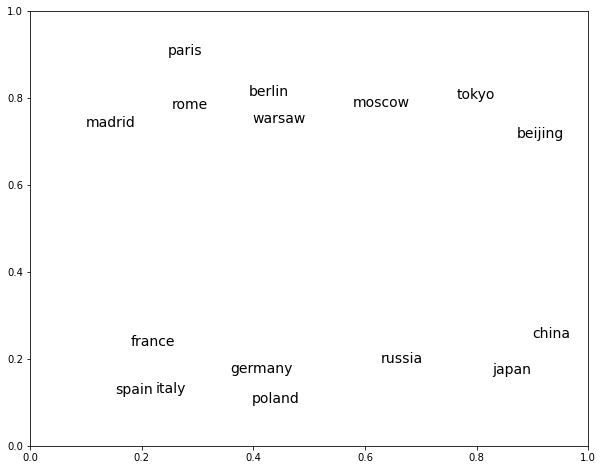

In [361]:
words = ['china', 'beijing', 'russia', 'moscow', 'poland', 'warsaw', 'japan', 'tokyo',
        'france', 'paris', 'germany', 'berlin', 'italy', 'rome', 'spain', 'madrid']

plot_words_embedding(glove, words)

Have you spot something interesting? Try with some other words set and see what you can find.

Clearly the first dimension(xaxis) indicates the geographical location of the country and city, meaning the countries and cities on the left hand side are all in Europe, while the ones on the right hand side in Asia. The second dimension(yaxis) indicates whether the entity is a country or capital city.

# Skip-gram

## Load the training data

In [97]:
text = load_data("plot_summaries_tokenized.txt")

print("Number of summarys: ", len(text))
print("Number of words:", len([w for s in text for w in s]))
print("Vocabulary size:", len({w for s in text for w in s}))

Number of summarys:  42306
Number of words: 13065221
Vocabulary size: 190786


There are about 200K unique words in this corpus. To make it more computational feasible, let's reduce the size of the vocabulary:

## Encode the text

In [99]:
from collections import Counter

In [103]:
MIN_COUNT = 20
def create_encoder(text, min_count=20):
    """
    - Create a encoder which is a dictionary like {word: index}
    - To reduce the total number of vocabularies, you can remove 
    the words that appear for less than min_count times in the entire
    corpus
    - Enfore {'_unknown_': 0}
    
    input:
        text: list of token list, e.g. [['i', 'am', 'fine'], ['another', 'summary'], ...]
    returns:
        tokenmap:  encoder dictionary
        tokenmap_reverse: reversed tokenmap {index: word} to faciliate inverse lookup
    """
    
    """
    Write your code here
    """
    tokenmap = {'__unknown__': 0}
    tokenmap_reverse = {0: '__unknown__'}
    c = Counter()
    for s in text:
        c.update(s)
    i = 1
    for w, cnt in c.items():
        if w not in tokenmap and cnt >= min_count:
            tokenmap[w] = i
            tokenmap_reverse[i] = w
            i += 1
    return tokenmap, tokenmap_reverse

In [104]:
tokenmap, tokenmap_reverse = create_encoder(text, MIN_COUNT)
VOCAB_SIZE = len(tokenmap)
print("the reduced vocabulary size is:", VOCAB_SIZE)

the reduced vocabulary size is: 26344


In [105]:
# Encoder the text using the encoder you just created
def encode(text, tokenmap, default=0):
    return [[tokenmap.get(t, default) for t in s] for s in text]

In [106]:
text_encoded = encode(text, tokenmap)

## Construct training context pairs

To generate training data, we need to find word-context pairs from the encoded text, 
we also want to generate some negative sample, so the input and output may look like:

for input corpus: [[2, 3, 1, 2]] 

returns: [[word, context, label]]

[[2, 3, 1], [2, 1, 1], [2, 2, 1], [3, 1, 1], ...., [4, 2, 0], [4, 3, 0], ...]

Notice that in practice the sequence should be shuffled.

In [245]:
from keras.preprocessing.sequence import skipgrams

def training_data_generator(text_encoded, window_size=4, negative_samples=1.0, batch_docs=50, vocab_size=VOCAB_SIZE, random_state=0):
    """
    For given encoded text, return 3 np.array:
    words, contexts, labels
    Do not pair the w and its context cross different documents.
    
    input: 
        text_encoded: list of list of int, each list of int is the numerical encoding of the doc
        window_size: int, define the context
        negative_samples: float, how much negative sampling you need, normally 1.0
        batch_docs: int, number of docs for which it generates one return
        
    return:
        words: list of int, the numerical encoding of the central words
        contexts: list of int, the numerical encoding of the context words
        labels: list of int, 1 or 0
        
    hint: 
    1. You can use skipgrams method from keras
    2. For training purpose, words and contexts needs to be 2D array, with shape (N, 1), 
       but labels is 1D array, with shape (N, )
    3. The output can be very big, you SHOULD using generator
    """
    
    """
    Write your code here
    """
    for i, _ in enumerate(text_encoded[::batch_docs]):
        words = []
        contexts = []
        labels = []
        for text in text_encoded[i*batch_docs:(i+1)*batch_docs]:
            res = skipgrams(text, vocabulary_size=vocab_size, negative_samples=negative_samples, seed=random_state)
            words.extend([x[0] for x in res[0]])
            contexts.extend([x[1] for x in res[0]])
            labels.extend(res[1])
        yield np.array(words)[:, None], np.array(contexts)[:, None], np.array(labels)

## Construct Learning Model

Now we need to create a network that looks like this:
<img src="skip-gram-NN.png" width="480">

In [246]:
"""
Write your code here
"""
from keras.layers import Input, Activation, Reshape, dot, Embedding, Permute
from tensorflow.keras.models import Model

# Define two input layers

input_words = Input(shape=(1,))
input_contexts = Input(shape=(1,))

# Embedding for the text
embed = Embedding(VOCAB_SIZE, 100, input_length=1)

embed1 = embed(input_words)
embed1 = Reshape((100,))(embed1)

embed2 = embed(input_contexts)
embed2 = Reshape((100,))(embed2)

# Concatenate the convolutional features and the vector input
dot_product = dot([embed1, embed2], axes=1, normalize=False)
output = Activation('sigmoid')(dot_product)

# define a model with a list of two inputs
model = Model(inputs=[input_words, input_contexts], outputs=output)
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 100)       2634400     input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 100)          0           embedding_3[0][0]          

## Train your model 

The following is a simple version of training on batch code. You do not need to use
opochs more than 10 since it will soon start shaking around the minimum. If you want 
to further improve your training, consider gradually increase the batch size or reduce 
the learning rate, then you can try for more than 10 epochs.

In [247]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop")

epochs = 10
ntot = 0
for epoch in range(epochs):
    print("Epoch %d ======" % epoch)
    for words, contexts, labels in training_data_generator(text_encoded, batch_docs=50):
        loss = model.train_on_batch(x=[words, contexts], y=labels)
        ntot += len(words)
        if ntot % 1e6 == 0:
            print("Total trained pairs (M): %10.2f ; \t loss: %.4f" % (ntot/1e6, loss))

Epoch 0 ======
Epoch 1 ======
Epoch 2 ======
Epoch 3 ======
Epoch 4 ======
Epoch 5 ======
Epoch 6 ======
Epoch 7 ======
Epoch 8 ======
Epoch 9 ======


## Transform the embedding to a table

Ready to translate the model you trained into the embedding DataFrame?

In [266]:
def embedding2df(embedding_layer, tokenmap_reverse):
    embedding =  pd.DataFrame(embedding_layer.get_weights()[0], tokenmap_reverse.values())
    return embedding.drop('__unknown__')

skip = embedding2df(model.layers[2], tokenmap_reverse)

In [331]:
from copy import copy

In [332]:
embedding_layer = copy(model.layers[2])

## Test your trained embedding

Use the embedding you just trained, repeat the exploration you did for Section 3.

spain     2.015376
korea     2.054043
region    2.106323
south     2.124574
asia      2.125982
dtype: float32
emperor    1.669467
roman      1.770087
count      1.788845
sir        1.821078
charles    1.825013
dtype: float32
russia      0.731792
germany     0.797386
moscow      0.885632
canada      0.900115
southern    0.901337
dtype: float32
9    0.943478
7    0.943649
6    1.037347
5    1.111455
4    1.339804
dtype: float64


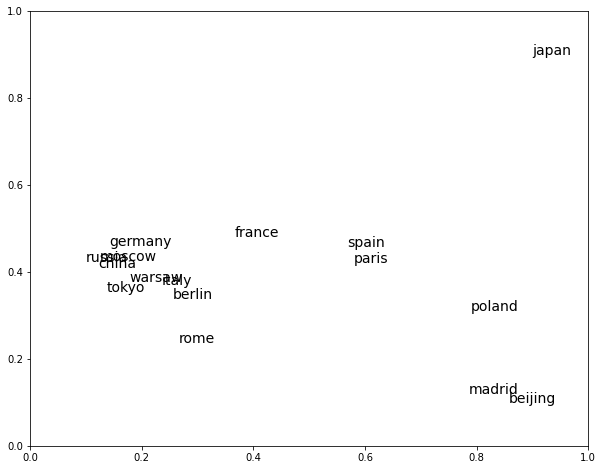

In [503]:
find_nearest_with_vector(skip.T,skip.T['king']-skip.T['male']+skip.T['female'])
words = ['china', 'beijing', 'russia', 'moscow', 'poland', 'warsaw', 'japan', 'tokyo',
        'france', 'paris', 'germany', 'berlin', 'italy', 'rome', 'spain', 'madrid']

plot_words_embedding(skip.T, words)
print(find_nearest_with_vector(skip.T, skip.T['china']+skip.T['capital']))
print(find_nearest_with_vector(skip.T, skip.T['king']-skip.T['male']+skip.T['female']))
print(find_nearest(skip.T, 'china'))
print(find_nearest(glove, '8'))

# Extra

## HW2

In [ ]:
# Try to use embedding to solve the previous 2 homeworks

In [282]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from utils.hw2 import load_data, save_prediction, read_vocab
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, GlobalMaxPooling1D

In [284]:
data = load_data("../HW02-CNN/train.txt")
vocab = read_vocab("../HW02-CNN/vocab.txt")
X, y = data.text, data.target
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.3)

In [287]:
# First let's see how you can build a similar CNN model you just had using Keras
MAX_LENGTH = 100

In [388]:
# Yes! it is a good practice to do data processing outside the ML model
wnet = WordNetLemmatizer()
# Numerical encode all the words
unknown = tokenmap['__unknown__']
X_train2 = [[tokenmap.get(wnet.lemmatize(w), unknown) for w in word_tokenize(sent)] for sent in X_train]
X_dev2 = [[tokenmap.get(wnet.lemmatize(w), unknown)for w in word_tokenize(sent)] for sent in X_dev]

# Tensorflow does not handle variable length input well, let's unify all input to the same length
def trim_X(X, max_length=100, default=vocab['.']):
    for i in range(len(X)):
        if len(X[i]) > max_length:
            X[i] = X[i][:max_length]
        elif len(X[i]) < max_length:
            X[i] = X[i] + [default] * (max_length - len(X[i]))
            
    return np.array(X)
            
X_train2 = trim_X(X_train2, MAX_LENGTH)
X_dev2 = trim_X(X_dev2, MAX_LENGTH)


# Now we have all the input data nicely encoded with numerical label, and each of the input data are trimmed 
# to have the same length. We would have needed to further apply one-hot encode for each word. However, this 
# would be very expensive, since each word will be expanded into a len(vocab) (~10000) length vector. Keras does
# not support sparse matrix input at this moment. But don't worry, we will use an advanced technique called embedding
# layer. This concept will be introduced in the next lesson. At this moment, you don't have to understand why.

### Use pretrained skipgram embedding

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pretrained_skipgram (Embeddi (None, 100, 100)          2634400   
_________________________________________________________________
Conv1D-1 (Conv1D)            (None, 98, 50)            15050     
_________________________________________________________________
MaxPooling1D-1 (GlobalMaxPoo (None, 50)                0         
_________________________________________________________________
Dense-1 (Dense)              (None, 1)                 51        
Total params: 2,649,501
Trainable params: 15,101
Non-trainable params: 2,634,400
_________________________________________________________________
None


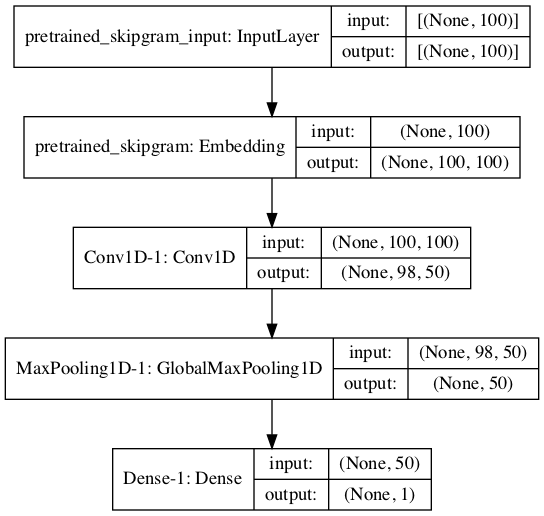

In [352]:
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, weights=embedding_layer.get_weights(), input_length=100, output_dim=100, name='pretrained_skipgram', trainable=False))
model.add(Conv1D(filters=50, kernel_size=3, activation="tanh", name="Conv1D-1"))
model.add(GlobalMaxPooling1D(name="MaxPooling1D-1"))
model.add(Dense(1, activation="sigmoid", name="Dense-1"))
print(model.summary())

show_keras_model(model)

In [353]:
# Train the model
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model.fit(X_train2, y_train, epochs=20, validation_data=(X_dev2, y_dev))

Epoch 1/20
219/219 [==============================] - 3s 10ms/step - loss: 0.6791 - accuracy: 0.5651 - val_loss: 0.6707 - val_accuracy: 0.5833
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.6462 - accuracy: 0.6339 - val_loss: 0.6551 - val_accuracy: 0.6080
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.6224 - accuracy: 0.6619 - val_loss: 0.6451 - val_accuracy: 0.6230
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.6022 - accuracy: 0.6879 - val_loss: 0.6405 - val_accuracy: 0.6240
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.5825 - accuracy: 0.7011 - val_loss: 0.6377 - val_accuracy: 0.6247
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.5636 - accuracy: 0.7210 - val_loss: 0.6324 - val_accuracy: 0.6323
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.5444 - accuracy: 0.7451 - val_loss: 0.6293 - val_accuracy: 0.6460
Epoc

### Use GloVe

In [438]:
glovemap = {x: i for i, x in enumerate(glove.columns)}

In [478]:
# Yes! it is a good practice to do data processing outside the ML model
wnet = WordNetLemmatizer()
# Numerical encode all the words, ignore unknown word in GloVe
X_train3 = []
for sent in X_train:
    ind = []
    for w in word_tokenize(sent):
        wl = wnet.lemmatize(w)
        if wl in glovemap:
            ind.append(glovemap[wl])
    X_train3.append(ind)
    
X_dev3 = []
for sent in X_dev:
    ind = []
    for w in word_tokenize(sent):
        wl = wnet.lemmatize(w)
        if wl in glovemap:
            ind.append(glovemap[wl])
    X_dev3.append(ind)

            
X_train3 = trim_X(X_train3, MAX_LENGTH)
X_dev3 = trim_X(X_dev3, MAX_LENGTH)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GloVe (Embedding)            (None, 100, 100)          10000000  
_________________________________________________________________
Conv1D-1 (Conv1D)            (None, 97, 100)           40100     
_________________________________________________________________
MaxPooling1D-1 (GlobalMaxPoo (None, 100)               0         
_________________________________________________________________
Dense-1 (Dense)              (None, 1)                 101       
Total params: 10,040,201
Trainable params: 40,201
Non-trainable params: 10,000,000
_________________________________________________________________
None


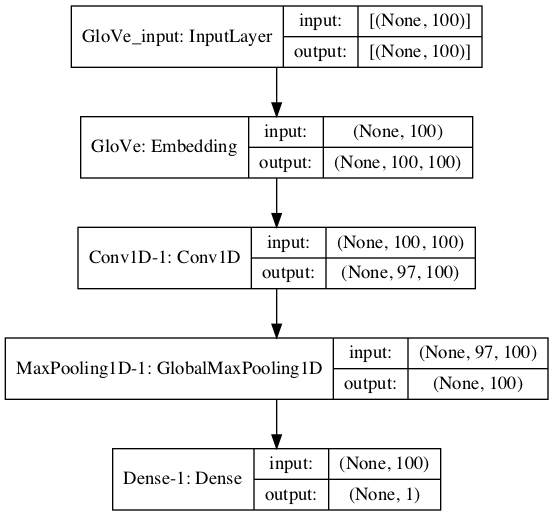

In [481]:
model = Sequential()
model.add(Embedding(input_dim=glove.shape[1], weights=[glove.T], input_length=100, output_dim=glove.shape[0], name='GloVe', trainable=False))
model.add(Conv1D(filters=100, kernel_size=4, activation="tanh", name="Conv1D-1"))
model.add(GlobalMaxPooling1D(name="MaxPooling1D-1"))
model.add(Dense(1, activation="sigmoid", name="Dense-1"))
print(model.summary())

show_keras_model(model)

In [482]:
# Train the model
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model.fit(X_train3, y_train, epochs=20, validation_data=(X_dev3, y_dev))

Epoch 1/20
219/219 [==============================] - 5s 18ms/step - loss: 0.6205 - accuracy: 0.6407 - val_loss: 0.5826 - val_accuracy: 0.6840
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.5066 - accuracy: 0.7541 - val_loss: 0.5482 - val_accuracy: 0.7073
Epoch 3/20
219/219 [==============================] - 3s 14ms/step - loss: 0.4445 - accuracy: 0.7977 - val_loss: 0.5536 - val_accuracy: 0.7117
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.3763 - accuracy: 0.8481 - val_loss: 0.5593 - val_accuracy: 0.7093
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.3166 - accuracy: 0.8831 - val_loss: 0.5657 - val_accuracy: 0.7173
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.2525 - accuracy: 0.9221 - val_loss: 0.5608 - val_accuracy: 0.7187
Epoch 7/20
219/219 [==============================] - 3s 13ms/step - loss: 0.1951 - accuracy: 0.9564 - val_loss: 0.6258 - val_accuracy: 0.7080

# Final project (Not due this week)

**Work with your teammates and start working on your final project proposal, think about these questions:**
- The problem you try to solve and the value of this problem
- Some current solution to this problem, reference citation if needed
- Outline your approach and the goal you want to achieve
